In [1]:
# uncomment the below line of code to install dependencies the first time the script is run
# !pip install numpy scipy pandas scikit-learn

In [2]:
# imports
import pandas as pd
import pickle
import glob
import numpy as np
from sklearn import *
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# read data
data_path = "/content/drive/My Drive/Colab_Notebooks/Eluvio/data/"     # to reproduce, change the data path 
model_path = "/content/drive/My Drive/Colab_Notebooks/Eluvio/"         # to save model to file later
filenames = glob.glob(data_path+"*.pkl")
unpickled_data = []

for f in filenames:
  unpickled_data.append(pickle.load(open(f, "rb")))

# look at data
print(type(unpickled_data[0]))
print("imdb_id: {}\n".format(unpickled_data[0]['imdb_id']))
print("place: {}\n".format(unpickled_data[0]['place']))
print("cast: {}\n".format(unpickled_data[0]['cast']))
print("action: {}\n".format(unpickled_data[0]['action']))
print("audio: {}\n".format(unpickled_data[0]['audio']))
print("scene_transition_boundary_ground_truth: {}\n".format(unpickled_data[0]['scene_transition_boundary_ground_truth']))
print("scene_transition_boundary_prediction: {}\n\n".format(unpickled_data[0]['scene_transition_boundary_prediction']))
print("scene_transition_boundary_ground_truth.shape: {}\n".format(unpickled_data[0]['scene_transition_boundary_ground_truth'].shape))

<class 'dict'>
imdb_id: tt0052357

place: tensor([[6.1556e-02, 1.0177e-01, 5.2085e-02,  ..., 6.7148e-02, 1.5965e-03,
         9.5967e-03],
        [5.2110e-02, 1.3152e-01, 4.7641e-02,  ..., 7.6565e-02, 1.4197e-03,
         1.1087e-02],
        [8.7748e-02, 2.4885e+00, 5.4332e-02,  ..., 7.1745e-01, 8.1299e-01,
         3.3096e-01],
        ...,
        [1.2349e-01, 4.4957e-01, 2.4556e-01,  ..., 1.0015e-02, 1.1907e-01,
         5.1556e-03],
        [1.9621e-02, 7.2868e-01, 2.4324e-01,  ..., 7.4836e-03, 3.7045e-02,
         7.4661e-02],
        [1.2028e-01, 2.9355e-01, 7.4574e-02,  ..., 4.0226e-02, 7.1149e-02,
         1.5697e-01]])

cast: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0073,  0.1230, -0.0396],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0309,  0.1172, -0.0647],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0290,  0.0804,  0

In [18]:
print("scene_transition_boundary_prediction.shape: {}\n\n".format(unpickled_data[0]['scene_transition_boundary_prediction'].shape))

scene_transition_boundary_prediction.shape: torch.Size([1100])




In [5]:
# pre-process features/target attribute so they're in the correct format for feeding into our neural network model
# num_data_files = len(unpickled_data)    

# print(len(filenames))
# print(len(filenames[:45]))
# print(len(filenames[45:]))

def preprocess_features(list_of_filenames):
  j = 0
  for i in range(len(list_of_filenames)):
    # read file
    inp_file = open(list_of_filenames[i], "rb")
    datafile = pickle.load(inp_file)
    inp_file.close()

    ft1, ft2, ft3, ft4 = datafile['place'].data.numpy(), datafile['cast'].data.numpy(), datafile['action'].data.numpy(), datafile['audio'].data.numpy()
    x = np.hstack((ft1, ft2, ft3, ft4))                       # features
    y = datafile['scene_transition_boundary_ground_truth']    

    # pre-process features
    scaler = preprocessing.MinMaxScaler().fit(x)
    x_transformed = scaler.transform(x)

    x_fold = np.zeros((x.shape[0] - 1, 2*x.shape[1]))
    for i in range(x.shape[0] - 1):
      x_fold[i,:] = np.hstack((x_transformed[i,:], x_transformed[i+1,:]))

    if j==0:
      X = x_fold
      Y = y
    else:
      X = np.concatenate((X, x_fold), axis=0)
      Y = np.concatenate((Y, y), axis=0)
    j += 1
  return X, Y


# split data into train and test sets - I'm using 70/30 for train/test; 70% of 64 is 44.8 so I rounded up to 45
X_train, y_train = preprocess_features(filenames[:45])
X_test, y_test = preprocess_features(filenames[45:])

print("X_train.shape: {}\n".format(X_train.shape))
print("y_train.shape: {}\n".format(y_train.shape))
print("X_test.shape: {}\n".format(X_test.shape))
print("y_test.shape: {}\n".format(y_test.shape))

X_train.shape: (70480, 7168)

y_train.shape: (70480,)

X_test.shape: (35497, 7168)

y_test.shape: (35497,)



AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


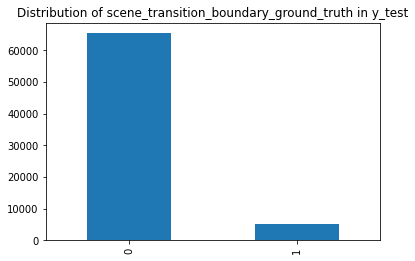

In [6]:
 # convert target attribute to 0/1 instead of False/True since the final predictions will be in integer form
def convert_labels(Y):
  Y_converted = np.zeros((Y.shape[0]), dtype = np.uint8)
  for i in range(Y.shape[0]):
      if Y[i]==True:
          Y_converted[i] = 1
      else:
          Y_converted[i] = 0
  return Y_converted

# convert both train and test labels
y_train_converted = convert_labels(y_train)
y_test_converted = convert_labels(y_test)

# plot distribution of target variable: train
target_df = pd.DataFrame(y_train_converted, columns=['scene_transition_boundary_ground_truth'])
print(target_df['scene_transition_boundary_ground_truth'].value_counts().plot(kind='bar', title="Distribution of scene_transition_boundary_ground_truth in y_train"))
# plot distribution of target variable: test
target_df = pd.DataFrame(y_test_converted, columns=['scene_transition_boundary_ground_truth'])
print(target_df['scene_transition_boundary_ground_truth'].value_counts().plot(kind='bar', title="Distribution of scene_transition_boundary_ground_truth in y_test"))

In [8]:
# evaluate preliminary predictions
# to reproduce, change directory to the directory where your data directory is
%cd /content/drive/MyDrive/Colab_Notebooks/Eluvio/   
!python evaluate_sceneseg.py data/

/content/drive/MyDrive/Colab_Notebooks/Eluvio
# of IMDB IDs: 64
Scores: {
    "AP": 0.4418872028438688,
    "mAP": 0.45644015956781614,
    "Miou": 0.4541480053002175,
    "Precision": 0.2761656092479825,
    "Recall": 0.7473442326299846,
    "F1": 0.39309552999275693
}


In [9]:
from numpy import loadtxt
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense

In [10]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(x=X_train, y=y_train_converted, epochs=50)
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train_converted, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

In [11]:
# save model to file
# save_model(model, model_path+"seq_model_2.h5")

NameError: ignored

In [12]:
# load model from file
model = load_model(model_path+"seq_model_2.h5")
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
# y_pred = [round(x[0]) for x in predictions]

In [17]:
print("type(predictions): {}".format(type(predictions)))
print("predictions.shape: {}".format(predictions.shape))
print(predictions)

type(predictions): <class 'numpy.ndarray'>
predictions.shape: (35497, 1)
[[0.03319377]
 [0.02613917]
 [0.00671345]
 ...
 [0.04637426]
 [0.30535126]
 [0.40110606]]


In [15]:
# save predictions to .pkl files similar to the input files so we can run the metrics
# fields needed for evaluation are "scene_transition_boundary_ground_truth", "scene_transition_boundary_prediction", "shot_end_frame", "imdb_id"
for i in range(len(filenames)):
  infile = open(filenames[i], "rb")
  datafile = pickle.load(infile)
  infile.close()
  # eval_features = ["scene_transition_boundary_ground_truth", "scene_transition_boundary_prediction", "shot_end_frame", "imdb_id"]
  # convert ground truth and predicitons to tensor format
  # gt = tf.convert_to_tensor(datafile["scene_transition_boundary_ground_truth"].data.numpy(), np.float32)
  # pred = tf.convert_to_tensor(y_pred, np.float32)
  eval_dict = dict([
      ("scene_transition_boundary_ground_truth", datafile["scene_transition_boundary_ground_truth"].data.numpy()),
      ("scene_transition_boundary_prediction", predictions),
      ("shot_end_frame", datafile["shot_end_frame"].data.numpy()),
      ("imdb_id", datafile["imdb_id"])
  ])
  # write eval_dict to .pkl file
  with open(data_path+"outs/"+datafile["imdb_id"]+".pkl", "wb") as f:
    pickle.dump(eval_dict, f)

In [21]:
# check that the output files were created correctly
check_file = open(data_path+"outs/tt0112573.pkl", "rb")
check_outs = pickle.load(check_file)
check_file.close()
print(type(check_outs))
print("imdb_id: {}\n".format(check_outs['imdb_id']))
print("scene_transition_boundary_ground_truth: {}\n".format(check_outs['scene_transition_boundary_ground_truth']))
print("scene_transition_boundary_prediction: {}\n\n".format(check_outs['scene_transition_boundary_prediction']))
print("scene_transition_boundary_ground_truth.shape: {}\n".format(check_outs['scene_transition_boundary_ground_truth'].shape))
print("scene_transition_boundary_prediction.shape: {}\n".format(check_outs['scene_transition_boundary_prediction'].shape))

<class 'dict'>
imdb_id: tt0112573

scene_transition_boundary_ground_truth: [False  True  True ... False False False]

scene_transition_boundary_prediction: [[0.03319377]
 [0.02613917]
 [0.00671345]
 ...
 [0.04637426]
 [0.30535126]
 [0.40110606]]


scene_transition_boundary_ground_truth.shape: (3095,)

scene_transition_boundary_prediction.shape: (35497, 1)



In [ ]:
# evaluate performance of generated predictions
%cd /content/drive/MyDrive/Colab_Notebooks/Eluvio/  
!python evaluate_sceneseg.py data/outs/

20 epochs:
Scores: {
    "AP": 0.4418872028438688,
    "mAP": 0.45644015956781614,
    "Miou": 0.4541480053002175,
    "Precision": 0.2761656092479825,
    "Recall": 0.7473442326299846,
    "F1": 0.39309552999275693
}

50 epochs: 